<a href="https://colab.research.google.com/github/Hwajun1323/ML/blob/master/convLSTM_precise_Adam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install keras-metrics

In [3]:
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score , cross_validate
import keras_metrics as km

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

In [4]:
data_dir = "/content/drive/My Drive/dataset/video_data"
#data_dir = "video_data/"
img_height, img_width = 64, 64
seq_len = 70

classes = ["Child's room",  "Museum", "Office", "Restaurant"]
num_classes = len(classes)
print("Number of Class: ", num_classes)

#  Creating frames from videos

def frames_extraction(video_path):
    frames_list = []

    vidObj = cv2.VideoCapture(video_path)
    # Used as counter variable
    count = 1

    while count <= seq_len:
        success, image = vidObj.read()
        if success:
            image = cv2.resize(image, (img_height, img_width))
            frames_list.append(image)
            count += 1
        else:
            print("Defected frame")
            break

    return frames_list

# Create the actual data from the sequence of images

def create_data(input_dir):
    X = []
    Y = []

    classes_list = os.listdir(input_dir)

    for c in classes_list:
        print(c)
        files_list = os.listdir(os.path.join(input_dir, c))
        for f in files_list:
            frames = frames_extraction(os.path.join(os.path.join(input_dir, c), f))
            if len(frames) == seq_len:
                X.append(frames)

                y = [0] * len(classes)
                y[classes.index(c)] = 1
                Y.append(y)

    X = np.asarray(X)
    Y = np.asarray(Y)
    
    return X, Y

Number of Class:  4


In [11]:
X, Y = create_data(data_dir)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, shuffle=True, random_state=0)

Child's room
Restaurant
Office
Defected frame
Defected frame
Museum


In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(816, 70, 64, 64, 3)
(205, 70, 64, 64, 3)
(816, 4)
(205, 4)


In [12]:
model = Sequential()

model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), return_sequences=False, data_format="channels_last", input_shape=(seq_len, img_height, img_width, 3)))
model.add(Dropout(0.3))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(GlobalAveragePooling2D())

model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation="softmax"))

model.summary()

opt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#opt = keras.optimizers.SGD(learning_rate=0.001)
#opt = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
#opt = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
#opt = keras.optimizers.Adagrad(learning_rate=0.001, epsilon=1e-6)
#opt = keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95, epsilon=None, decay=0.0)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])

history = model.fit(x=X_train, y=y_train, epochs=80, batch_size=12, shuffle=True, validation_split=0.2)

# Result
loss, acc = model.evaluate(X_test, y_test)
print("\nLoss: {}, Acc: {}".format(loss,acc))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_2 (ConvLSTM2D)  (None, 62, 62, 64)        154624    
_________________________________________________________________
dropout_6 (Dropout)          (None, 62, 62, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 62, 62, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 64)                0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)              

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


55/55 [==============================] - 46s 790ms/step - loss: 1.4151 - accuracy: 0.3645 - val_loss: 1.3531 - val_accuracy: 0.3598
Epoch 2/80
55/55 [==============================] - 43s 776ms/step - loss: 1.3383 - accuracy: 0.3860 - val_loss: 1.3386 - val_accuracy: 0.3598
Epoch 3/80
55/55 [==============================] - 43s 776ms/step - loss: 1.2603 - accuracy: 0.4592 - val_loss: 1.3411 - val_accuracy: 0.3537
Epoch 4/80
55/55 [==============================] - 43s 776ms/step - loss: 1.3076 - accuracy: 0.3896 - val_loss: 1.3783 - val_accuracy: 0.3598
Epoch 5/80
55/55 [==============================] - 43s 776ms/step - loss: 1.3294 - accuracy: 0.4005 - val_loss: 1.3452 - val_accuracy: 0.3598
Epoch 6/80
55/55 [==============================] - 43s 776ms/step - loss: 1.3237 - accuracy: 0.3872 - val_loss: 1.3543 - val_accuracy: 0.3537
Epoch 7/80
55/55 [==============================] - 43s 777ms/step - loss: 1.2883 - accuracy: 0.4486 - val_loss: 1.3350 - val_accuracy: 0.3476
Epoch 8/80

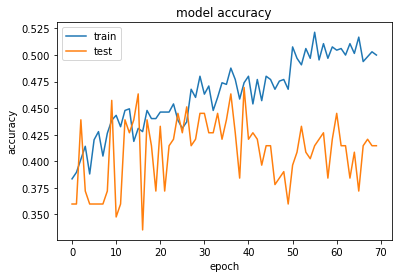

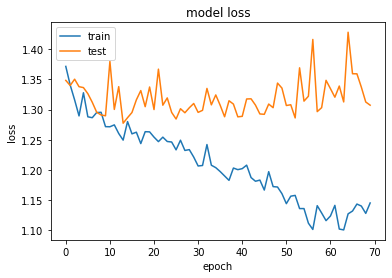

In [7]:
# Visualize the plot

## summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
## summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
predictions = model.predict(X_test)
print('prediction result: ',np.argmax(predictions[0]))
print('actual result: ', y_test[0])

# Evaluation of model
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
print('classification report\n')
print(classification_report(y_test, y_pred))

In [13]:
# Evaluation of model
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)
print('y test:', y_test)
print('Classification Report:\n')
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred) 
print('confusion matrix:\n ', cm)

y test: [1 0 0 3 3 0 3 2 1 2 2 2 2 1 3 1 3 3 3 3 0 0 3 0 2 2 3 0 3 1 1 3 2 1 1 0 3
 3 3 3 2 0 2 0 1 3 3 2 0 3 3 1 3 2 1 1 3 1 0 2 3 1 3 0 1 3 3 2 3 1 1 2 1 0
 3 3 0 1 1 1 1 0 2 1 3 3 2 3 1 3 3 0 3 3 1 2 3 1 0 3 1 1 1 1 0 1 3 1 2 1 2
 3 2 3 3 1 3 3 1 2 3 3 1 2 0 3 1 3 3 2 3 3 3 2 3 3 1 0 3 3 1 1 3 2 2 1 3 3
 3 0 1 1 0 3 3 1 2 3 3 3 0 0 3 0 1 2 2 3 3 3 2 1 3 2 1 2 1 3 1 3 3 3 3 1 1
 0 3 3 3 3 3 3 1 0 1 3 3 2 3 2 2 3 3 3 2]
Classification Report:

              precision    recall  f1-score   support

           0       0.35      0.32      0.33        28
           1       0.40      0.42      0.41        53
           2       0.48      0.54      0.51        37
           3       0.57      0.54      0.56        87

    accuracy                           0.48       205
   macro avg       0.45      0.45      0.45       205
weighted avg       0.48      0.48      0.48       205

confusion matrix:
  [[ 9  5  9  5]
 [ 7 22  4 20]
 [ 4  3 20 10]
 [ 6 25  9 47]]
